In [34]:
from src.MOMA_DQN import MOMA_DQN
import torch
import mo_gymnasium as mo_gym
from src.gridsearch import gridsearch
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from matplotlib import pyplot as plt

### Configure and run the experiments

In [2]:
env = mo_gym.make('moma-highway-env-v0', render_mode='rgb_array')
env.unwrapped.configure({
    "screen_width": 500,
    "screen_height": 500,
    "vehicles_count": 10,
    "controlled_vehicles": 2,
    "observation": {
        "type": "AugmentedMultiAgentObservation",
        "observation_config": {
            "type": "AugmentedMultiAgentObservation",
            "see_behind": False, 
            "features": ['presence', 'x', 'y', 'vx', 'vy', 'obj_weights', "lane_info"]
        }
    },
    "action": {
        "type": "MultiAgentAction",
        "action_config": {
            "type": "DiscreteMetaAction",
        }
    }
})

obs, info = env.reset()
obs = [torch.tensor(single_obs) for single_obs in obs] #reshape observations and
obs = [single_obs[~torch.isnan(single_obs)].reshape(1,-1) for single_obs in obs] #remove nan values
moma_agent = MOMA_DQN(env, num_objectives=2, seed=11, observation_space_length=obs[0].shape[1], replay_buffer_size=1000, batch_ratio=0.3,
                      objective_names=["speed_reward", "energy_reward"])
moma_agent.train(10_000, epsilon_start=0.9, epsilon_end=0.0)

df = moma_agent.evaluate(num_repetitions= 20, hv_reference_point=np.ndarray([0,0]), seed=11, episode_recording_interval=None, num_points=30)
print(df)
df.to_csv("data/marl.csv")

Weight tuple: 100%|██████████| 30/30 [06:39<00:00, 13.32s/it]

      repetition_number  weight_index weight_tuple  num_iterations  \
0                     0             0   [0.0, 1.0]              24   
1                     0             0   [0.0, 1.0]              24   
2                     1             0   [0.0, 1.0]              80   
3                     1             0   [0.0, 1.0]              80   
4                     2             0   [0.0, 1.0]              80   
...                 ...           ...          ...             ...   
1195                 17            29   [1.0, 0.0]              20   
1196                 18            29   [1.0, 0.0]              80   
1197                 18            29   [1.0, 0.0]              80   
1198                 19            29   [1.0, 0.0]              80   
1199                 19            29   [1.0, 0.0]              80   

      vehicle_id  normalised_speed_reward  normalised_energy_reward  \
0              0                 0.241068                  0.892555   
1              1 

### Data preprocessing

In [3]:
#load the data
df_complete = pd.read_csv("data/marl.csv")
display(df_complete.info())
display(df_complete)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1200 non-null   int64  
 1   repetition_number         1200 non-null   int64  
 2   weight_index              1200 non-null   int64  
 3   weight_tuple              1200 non-null   object 
 4   num_iterations            1200 non-null   int64  
 5   vehicle_id                1200 non-null   int64  
 6   normalised_speed_reward   1200 non-null   float64
 7   normalised_energy_reward  1200 non-null   float64
 8   raw_speed_reward          1200 non-null   float64
 9   raw_energy_reward         1200 non-null   float64
dtypes: float64(4), int64(5), object(1)
memory usage: 93.9+ KB


None

,Unnamed: 0,repetition_number,weight_index,weight_tuple,num_iterations,vehicle_id,normalised_speed_reward,normalised_energy_reward,raw_speed_reward,raw_energy_reward
0,0,0,0,"[0.0, 1.0]",24,0,0.241068,0.892555,5.785633,21.421332
1,1,0,0,"[0.0, 1.0]",24,1,0.271312,0.891398,6.511485,21.393555
2,2,1,0,"[0.0, 1.0]",80,0,0.309965,0.878871,24.797198,70.309655
3,3,1,0,"[0.0, 1.0]",80,1,0.413989,0.835495,33.119099,66.839587
4,4,2,0,"[0.0, 1.0]",80,0,0.244121,0.897591,19.529677,71.807315
...,...,...,...,...,...,...,...,...,...,...
1195,1195,17,29,"[1.0, 0.0]",20,1,0.565848,0.764053,11.316967,15.281056
1196,1196,18,29,"[1.0, 0.0]",80,0,0.734655,0.684999,58.772429,54.799892
1197,1197,18,29,"[1.0, 0.0]",80,1,0.779393,0.687927,62.351426,55.034150
1198,1198,19,29,"[1.0, 0.0]",80,0,0.743999,0.683756,59.519886,54.700501


In [14]:
value_columns = ["normalised_speed_reward", "normalised_energy_reward"]
grouped_df = df_complete.groupby(["weight_index", "vehicle_id"])[value_columns].mean()
grouped_df = grouped_df.reset_index()
grouped_df["pareto"] = False

#add pareto information
nds = NonDominatedSorting()
for v_id in grouped_df["vehicle_id"].unique():
    data = grouped_df[grouped_df["vehicle_id"] == v_id]
    pareto_indices = nds.do(data[value_columns], only_non_dominated_front=True)
    grouped_df.loc[(grouped_df["vehicle_id"] == v_id) & (data["weight_index"].isin(pareto_indices)), "pareto"] = True

<Axes: xlabel='normalised_speed_reward', ylabel='normalised_energy_reward'>

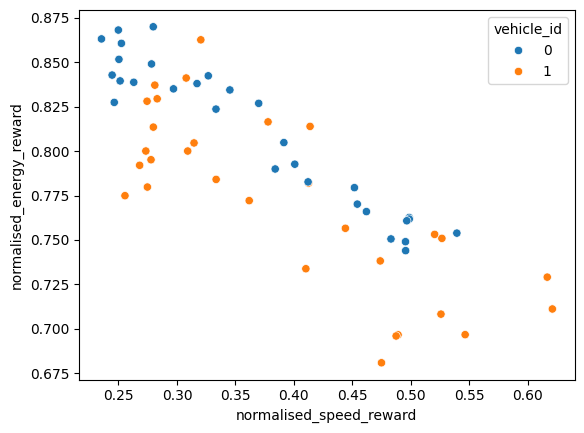

In [19]:
#plot all points
import seaborn as sns
sns.scatterplot(data=grouped_df, x='normalised_speed_reward', y='normalised_energy_reward', hue="vehicle_id")

<Axes: xlabel='weight_index'>

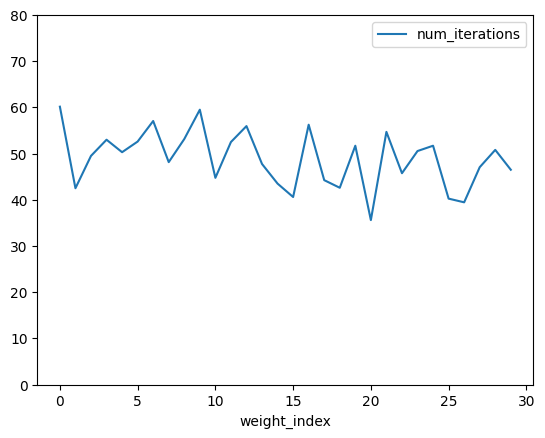

In [41]:
#num iterations
grouped_df_mean = df_complete.groupby(["weight_index", "vehicle_id"])["num_iterations"].mean()
grouped_df_mean = grouped_df.reset_index()

#num iterations
grouped_df_std = df_complete.groupby(["weight_index", "vehicle_id"])["num_iterations"].std()
grouped_df_std = grouped_df.reset_index()

grouped_df_mean.plot(x="weight_index", y="num_iterations",ylim=(0, 80))